In [184]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

In [185]:
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [186]:
train_data = pd.read_csv('Econ148_project_part1_train.csv')
future_data = pd.read_csv('Econ148_project_part1_future.csv')

print(f"Training data shape: {train_data.shape}")
print(f"Future data shape: {future_data.shape}")

Training data shape: (372192, 56)
Future data shape: (352383, 56)


In [187]:
print("\nFirst few rows of training data:")
print(train_data.head())

print("\nData types:")
print(train_data.dtypes)

print("\nMissing values summary:")
train_missing = train_data.isna().sum() / len(train_data) * 100
print(train_missing[train_missing > 0].sort_values(ascending=False))

print("\nTarget distribution:")
print(train_data['target'].value_counts(normalize=True) * 100)


First few rows of training data:
   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0         51    12525.8       3460        0.0     1879.0        NaN   
1         71        0.0       3596        0.0        NaN        NaN   
2         80        0.0       2098        0.0        NaN        NaN   
3          6        NaN       2460        0.0        NaN        NaN   
4         59    13968.4       3059        0.0     3492.2        NaN   

   Feature_7  Feature_8  Feature_9  Feature_10  ...  Feature_47  Feature_48  \
0  4287.4000     1879.0    62795.0         0.0  ...         NaN         NaN   
1        NaN        NaN    30560.0         0.0  ...         NaN         NaN   
2        NaN        NaN    12998.0         0.0  ...         NaN         NaN   
3        NaN        NaN    26000.0         0.0  ...         NaN         NaN   
4  5238.3003     3492.2    50000.0         0.0  ...   5357.8003         NaN   

   Feature_49  Feature_50 Feature_51 Feature_52  Feature_53 Feat

In [188]:
def identify_column_types(df, id_col='id', target_col='target'):
    """Identify numeric, categorical, and boolean columns."""
    # Remove id and target columns
    feature_cols = [col for col in df.columns if col not in [id_col, target_col]]
    
    numeric_cols = []
    categorical_cols = []
    boolean_cols = []
    
    for col in feature_cols:
        if df[col].dtype == 'bool':
            boolean_cols.append(col)
        elif pd.api.types.is_numeric_dtype(df[col]):
            if len(df[col].dropna().unique()) <= 15:  # Threshold for categorical
                categorical_cols.append(col)
            else:
                numeric_cols.append(col)
        else:
            categorical_cols.append(col)
    
    return numeric_cols, categorical_cols, boolean_cols

def analyze_sparsity(df):
    """Analyze how sparse each column is."""
    nan_counts = df.isna().sum()
    zero_counts = (df == 0).sum()
    total_sparse = nan_counts + zero_counts
    sparsity = total_sparse / len(df) * 100
    
    return sparsity.sort_values(ascending=False)

def create_preprocessing_pipeline(numeric_cols, categorical_cols, boolean_cols):
    """Create preprocessing pipeline for different column types."""
    # Preprocessing for numerical columns
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    
    # Preprocessing for categorical columns
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    # Preprocessing for boolean columns
    boolean_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent'))
    ])
    
    # Combine transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, categorical_cols),
            ('bool', boolean_transformer, boolean_cols)
        ],
        remainder='drop'  # This drops the ID column
    )
    
    return preprocessor

def add_missing_indicators(X, numeric_cols):
    """Add binary columns indicating whether values were missing."""
    missing_indicator_cols = []
    for col in numeric_cols:
        if X[col].isna().sum() > 0:
            indicator_name = f"{col}_is_missing"
            X[indicator_name] = X[col].isna().astype(int)
            missing_indicator_cols.append(indicator_name)
    return X, missing_indicator_cols

In [189]:
def engineer_features(df):
    """Create new features that might be helpful."""
    df_copy = df.copy()
    
    # Feature interaction: product of selected non-zero features
    # Start by selecting features with moderate sparsity (not too sparse)
    sparsity = analyze_sparsity(df_copy)
    moderate_sparse_cols = sparsity[(sparsity > 50) & (sparsity < 90)].index.tolist()
    moderate_sparse_cols = [col for col in moderate_sparse_cols if 
                        col != 'id' and 
                        col != 'target' and 
                        pd.api.types.is_numeric_dtype(df_copy[col])]
    
    # Use only a few columns for interactions to avoid dimensionality explosion
    if len(moderate_sparse_cols) >= 2:
        selected_cols = moderate_sparse_cols[:2]
        df_copy['interaction'] = df_copy[selected_cols[0]].fillna(0) * df_copy[selected_cols[1]].fillna(0)
    
    # Aggregate features
    numeric_cols, _, _ = identify_column_types(df_copy)
    if numeric_cols:
        df_copy['mean_of_features'] = df_copy[numeric_cols].mean(axis=1)
        df_copy['sum_of_features'] = df_copy[numeric_cols].sum(axis=1)
        df_copy['count_non_zero'] = df_copy[numeric_cols].replace(0, np.nan).count(axis=1)
        df_copy['count_missing'] = df_copy[numeric_cols].isna().sum(axis=1)
    
    return df_copy

In [190]:
train_data['Feature_51'] = train_data['Feature_51'].astype(int)

In [191]:
print("\nPreparing data...")
# Identify column types
numeric_cols, categorical_cols, boolean_cols = identify_column_types(train_data)
print(f"Numeric columns: {len(numeric_cols)}")
print(f"Categorical columns: {len(categorical_cols)}")
print(f"Boolean columns: {len(boolean_cols)}")

# Analyze sparsity
sparsity = analyze_sparsity(train_data)
print("\nTop 10 most sparse columns:")
print(sparsity.head(10))

# Engineer features
train_data_eng = engineer_features(train_data)
future_data_eng = engineer_features(future_data)

# Add missing indicators
# train_data_eng, missing_indicator_cols = add_missing_indicators(train_data_eng, numeric_cols)
# future_data_eng, _ = add_missing_indicators(future_data_eng, numeric_cols)

# Update column lists with new features
new_numeric_cols = [col for col in train_data_eng.columns if 
                   col not in train_data.columns and
                   pd.api.types.is_numeric_dtype(train_data_eng[col]) and
                #    col not in missing_indicator_cols and
                   col != 'target']
numeric_cols.extend(new_numeric_cols)
# boolean_cols.extend(missing_indicator_cols)

print(train_data_eng.columns.tolist())

# Split the data
X = train_data_eng.drop(['id', 'target'], axis=1)
y = train_data_eng['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create preprocessing pipeline
preprocessor = create_preprocessing_pipeline(numeric_cols, categorical_cols, boolean_cols)

# Fit the preprocessor
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

print(f"Processed training data shape: {X_train_processed.shape}")
print(f"Processed validation data shape: {X_val_processed.shape}")


Preparing data...
Numeric columns: 38
Categorical columns: 16
Boolean columns: 0

Top 10 most sparse columns:
Feature_20    99.921546
Feature_19    99.839330
Feature_54    98.984933
Feature_53    98.964244
Feature_51    98.091308
target        96.602291
Feature_48    95.369326
Feature_28    95.048255
Feature_13    94.034799
Feature_52    93.411196
dtype: float64
['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14', 'Feature_15', 'Feature_16', 'Feature_17', 'Feature_18', 'Feature_19', 'Feature_20', 'Feature_21', 'Feature_22', 'Feature_23', 'Feature_24', 'Feature_25', 'Feature_26', 'Feature_27', 'Feature_28', 'Feature_29', 'Feature_30', 'Feature_31', 'Feature_32', 'Feature_33', 'Feature_34', 'Feature_35', 'Feature_36', 'Feature_37', 'Feature_38', 'Feature_39', 'Feature_40', 'Feature_41', 'Feature_42', 'Feature_43', 'Feature_44', 'Feature_45', 'Feature_46'

In [192]:
def select_features(X_train_processed, y_train, X_val_processed, num_features=None):
    """Select top k features based on ANOVA F-value."""
    if num_features is None:
        num_features = min(X_train_processed.shape[1], 200)  # Default to 200 or less
    
    selector = SelectKBest(f_classif, k=num_features)
    X_train_selected = selector.fit_transform(X_train_processed, y_train)
    X_val_selected = selector.transform(X_val_processed)
    
    return X_train_selected, X_val_selected, selector

# Apply feature selection
num_features = min(X_train_processed.shape[1], 200)  # Select top 200 features or less
X_train_selected, X_val_selected, selector = select_features(X_train_processed, y_train, X_val_processed, num_features)

print(f"Selected features shape: {X_train_selected.shape}")

Selected features shape: (297753, 200)


In [193]:
class SparseDataset(Dataset):
    def __init__(self, features, labels=None):
        self.features = torch.tensor(features, dtype=torch.float32)
        if labels is not None:
            self.labels = torch.tensor(labels.values, dtype=torch.float32)
        else:
            self.labels = None
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        if self.labels is not None:
            return self.features[idx], self.labels[idx]
        else:
            return self.features[idx]

# Create datasets
train_dataset = SparseDataset(X_train_selected, y_train)
val_dataset = SparseDataset(X_val_selected, y_val)

# Calculate class weights for imbalanced data
class_counts = y_train.value_counts().to_dict()
total_samples = len(y_train)
pos_weight = class_counts[0] / class_counts[1] if 1 in class_counts else 1.0

# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=256, 
    shuffle=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=512, 
    shuffle=False
)

In [200]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.4)
        
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.3)
        
        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        self.dropout4 = nn.Dropout(0.2)
        
        self.fc5 = nn.Linear(32, 1)
        
        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout3(x)
        
        x = self.fc4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.dropout4(x)
        
        x = self.fc5(x)
        x = self.sigmoid(x)
        
        return x

# Initialize model, loss function, and optimizer
model = NeuralNetwork(input_dim=X_train_selected.shape[1]).to(device)
criterion = nn.BCELoss(weight=torch.tensor([pos_weight], device=device))
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, min_lr=1e-7)

In [201]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=100, patience=10):
    """Train the neural network model."""
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_state = model.state_dict()
    patience_counter = 0
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device).view(-1, 1)
            
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * features.size(0)
        
        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device).view(-1, 1)
                outputs = model(features)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * features.size(0)
        
        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        
        # LR scheduler
        scheduler.step(val_loss)
        
        # Print progress
        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')
        
        # Save best model and check early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
    
    # Load the best model
    model.load_state_dict(best_model_state)
    return model, train_losses, val_losses

# Train model
print("\nTraining model...")
model, train_losses, val_losses = train_model(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    scheduler,
    epochs=100,
    patience=10
)

# Save the best model
torch.save(model.state_dict(), 'best_model.pt')
print("Best model saved to 'best_model.pt'")


Training model...
Epoch 5/100, Train Loss: 3.483909, Val Loss: 3.419113
Epoch 10/100, Train Loss: 3.418946, Val Loss: 3.417732
Epoch 15/100, Train Loss: 3.390085, Val Loss: 3.399624
Epoch 20/100, Train Loss: 3.367098, Val Loss: 3.411599
Epoch 25/100, Train Loss: 3.304673, Val Loss: 3.399322
Early stopping at epoch 27
Best model saved to 'best_model.pt'


In [ ]:
model = torch.load('best_model.pt')


Evaluating model...
Validation F1 Score: 0.3704

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98     71910
         1.0       0.35      0.39      0.37      2529

    accuracy                           0.95     74439
   macro avg       0.66      0.68      0.67     74439
weighted avg       0.96      0.95      0.96     74439



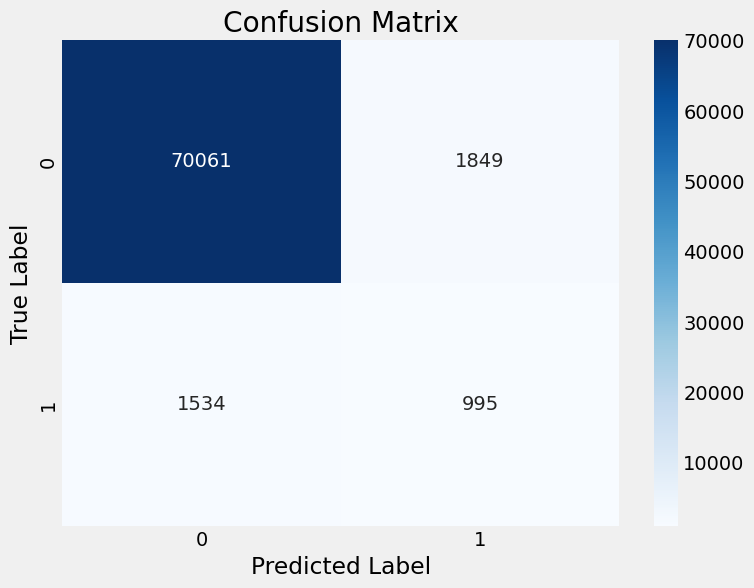

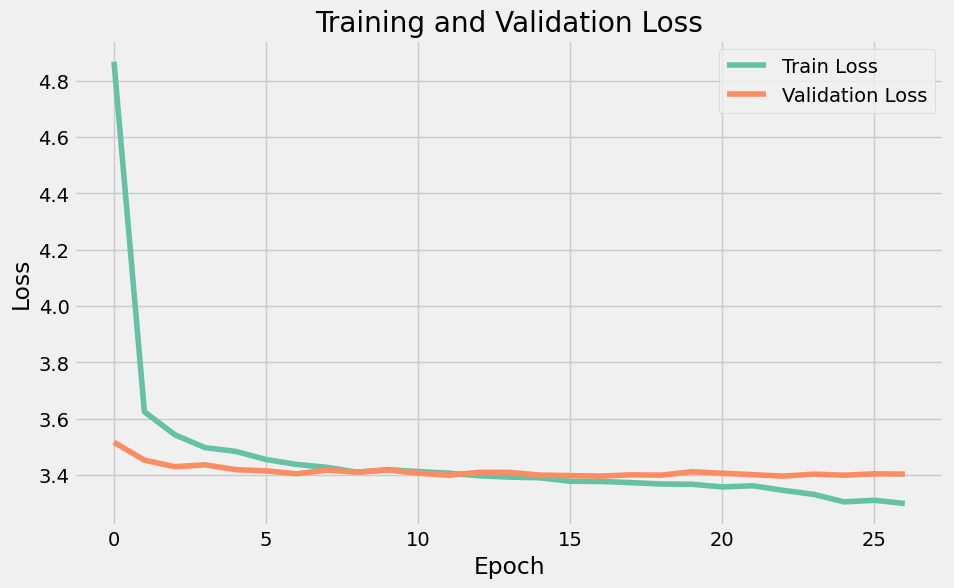

In [205]:
print("\nEvaluating model...")
def get_predictions(model, data_loader):
    """Get predictions from the model."""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for features, labels in data_loader:
            features = features.to(device)
            outputs = model(features)
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    return np.array(all_preds).flatten(), np.array(all_labels)

# Get predictions
y_val_pred_proba, y_val_true = get_predictions(model, val_loader)
y_val_pred = (y_val_pred_proba > 0.25).astype(int)

# Calculate metrics
val_f1 = f1_score(y_val_true, y_val_pred)
print(f"Validation F1 Score: {val_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_val_true, y_val_pred))

# Plot confusion matrix
cm = confusion_matrix(y_val_true, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [204]:
def optimize_threshold(y_true, y_pred_proba):
    """Find the optimal threshold to maximize F1 score."""
    thresholds = np.arange(0.1, 0.9, 0.01)
    f1_scores = []
    
    for threshold in thresholds:
        y_pred = (y_pred_proba > threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        f1_scores.append(f1)
    
    best_threshold = thresholds[np.argmax(f1_scores)]
    best_f1 = max(f1_scores)
    
    return best_threshold, best_f1

# Find the optimal threshold
print("\nOptimizing threshold for F1 score...")
best_threshold, best_f1 = optimize_threshold(y_val_true, y_val_pred_proba)
print(f"Optimal threshold: {best_threshold:.4f}")
print(f"Best F1 score: {best_f1:.4f}")

# Apply the optimal threshold
y_val_pred_optimized = (y_val_pred_proba > best_threshold).astype(int)
print("\nOptimized Classification Report:")
print(classification_report(y_val_true, y_val_pred_optimized))


Optimizing threshold for F1 score...
Optimal threshold: 0.2500
Best F1 score: 0.3704

Optimized Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98     71910
         1.0       0.35      0.39      0.37      2529

    accuracy                           0.95     74439
   macro avg       0.66      0.68      0.67     74439
weighted avg       0.96      0.95      0.96     74439



In [ ]:
print("\nPredicting on future data...")
# Preprocess future data
X_future = future_data_eng.drop(['id', 'target'], axis=1)
X_future_processed = preprocessor.transform(X_future)
X_future_selected = selector.transform(X_future_processed)

# Convert to PyTorch tensor
future_dataset = SparseDataset(X_future_selected)
future_loader = DataLoader(future_dataset, batch_size=512, shuffle=False)

# Predict
model.eval()
future_preds = []
with torch.no_grad():
    for features in future_loader:
        if isinstance(features, list):
            features = features[0]  # No labels in this dataset
        features = features.to(device)
        outputs = model(features)
        future_preds.extend(outputs.cpu().numpy())

future_pred_proba = np.array(future_preds).flatten()
future_predictions = (future_pred_proba > best_threshold).astype(int)

# Create submission dataframe
submission = pd.DataFrame({
    'id': future_data['id'],
    'prediction': future_predictions
})

# Save submission
submission.to_csv('Part1_prediction.csv', index=False, header=True)
print("Predictions saved to 'model_predictions.csv'")


Predicting on future data...
Predictions saved to 'model_predictions.csv'


In [ ]:
d1 = pd.read_csv('Part1_prediction.csv')
d2 = pd.read_csv('Econ148_project_part1_future.csv')

for id1, id2 in zip(d1['id'], d2['id']):
    if id1 != id2:
        print(f"ID mismatch: {id1} != {id2}")
print("ID check passed. All IDs match between predictions and future data.")

ID check passed. All IDs match between predictions and future data.
